In [376]:
%matplotlib inline
import os, sys

import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
import pandas as pd
import yaml

import pcse
from pcse.models import Wofost72_WLP_FD, Wofost80_NWLP_FD_beta, LINTUL3
from pcse.fileinput import CABOFileReader, YAMLCropDataProvider, PCSEFileReader
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import WOFOST72SiteDataProvider, WOFOST80SiteDataProvider
from pcse.base import ParameterProvider
from pcse.fileinput import YAMLAgroManagementReader

In [377]:
print(os.getcwd())

/home/tmrob2/PycharmProjects/farming-gym


In [378]:
data_dir = os.path.join(os.getcwd(), 'farm_gym/envs/env_data/')

In [379]:
crop_params_dir = os.path.join(data_dir, 'crop_params/')
crop = YAMLCropDataProvider(crop_params_dir)

YAMLCropDataProvider - Failed to load cache file: [Errno 2] No such file or directory: 'barley'


In [380]:
crop.get_crops_varieties()

{'barley': dict_keys(['Spring_barley_301']),
 'cassava': dict_keys(['Cassava_VanHeemst_1988']),
 'chickpea': dict_keys(['Chickpea_VanHeemst_1988']),
 'cotton': dict_keys(['Cotton_VanHeemst_1988']),
 'cowpea': dict_keys(['Cowpea_VanHeemst_1988']),
 'fababean': dict_keys(['Faba_bean_801']),
 'groundnut': dict_keys(['Groundnut_VanHeemst_1988']),
 'maize': dict_keys(['Maize_VanHeemst_1988', 'Grain_maize_201', 'Grain_maize_202', 'Grain_maize_203', 'Grain_maize_204', 'Grain_maize_205']),
 'millet': dict_keys(['Millet_VanHeemst_1988']),
 'mungbean': dict_keys(['Mungbean_VanHeemst_1988']),
 'pigeonpea': dict_keys(['Pigeonpea_VanHeemst_1988']),
 'potato': dict_keys(['Potato_701', 'Potato_702', 'Potato_703', 'Potato_704']),
 'rapeseed': dict_keys(['Oilseed_rape_1001', 'Oilseed_rape_1002', 'Oilseed_rape_1003', 'Oilseed_rape_1004']),
 'rice': dict_keys(['Rice_501', 'Rice_HYV_IR8', 'Rice_IR64616H_DS', 'Rice_IR64616H_WS', 'Rice_IR64', 'Rice_IR72', 'Rice_IR72_DS', 'Rice_IR72_WS', 'Rice_IR8A']),
 'sor

In [381]:
soil_data = os.path.join(data_dir, 'SOILD', 'EC2.NEW')
soil = CABOFileReader(soil_data)
#soil = PCSEFileReader(soil_data)

In [382]:
sited = WOFOST72SiteDataProvider(WAV=10)

In [383]:
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=sited)

In [384]:
def get_weatherdataprovider(lat, long):
    location = (lat, long)
    return pcse.db.NASAPowerWeatherDataProvider(*location)
wdp = get_weatherdataprovider(-36.626230, 142.188370)
#wdp = get_weatherdataprovider(51.970, 5.670)
print(wdp)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER CERES/MERRA2 Native Resolution Daily Data
----Site characteristics----
Elevation:  133.0
Latitude:  -36.626
Longitude: 142.188
Data available for 1984-01-01 - 2022-07-24
Number of missing days: 1



In [385]:
agro_dir = os.path.join(os.getcwd(), "farm_gym/envs/env_data/agro/")
agromanagement_file = os.path.join(agro_dir, 'baseline_4yr_model.yaml')
agromanagement = YAMLAgroManagementReader(agromanagement_file)
print(agromanagement)

!!python/object/new:pcse.fileinput.yaml_agro_loader.YAMLAgroManagementReader
listitems:
- 2006-01-01:
    CropCalendar:
      crop_end_date: 2006-12-20
      crop_end_type: earliest
      crop_name: wheat
      crop_start_date: 2006-04-01
      crop_start_type: sowing
      max_duration: 300
      variety_name: Winter_wheat_101
    StateEvents: null
    TimedEvents:
    - comment: All irrigation amounts in cm
      event_signal: irrigate
      events_table:
      - 2006-05-10:
          amount: 20
          efficiency: 0.7
      - 2006-05-20:
          amount: 20
          efficiency: 0.7
      - 2006-07-10:
          amount: 20
          efficiency: 0.7
      - 2006-08-10:
          amount: 20
          efficiency: 0.7
      - 2006-09-05:
          amount: 5
          efficiency: 0.7
      name: Irrigation application table
- 2007-01-01:
    CropCalendar:
      crop_end_date: 2007-12-20
      crop_end_type: earliest
      crop_name: wheat
      crop_start_date: 2007-04-01
      crop_s

In [386]:
wofost = Wofost72_WLP_FD(parameterprovider, wdp, agromanagement)
wofost.run_till_terminate()

In [387]:
output = wofost.get_output()
df = pd.DataFrame(output).set_index("day")
df.tail()

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2009-12-11,1.947563,0.0,19433.239686,5483.01354,5227.142146,8723.083999,2809.960704,0.0,120.0,0.146034,17.524046
2009-12-12,1.960796,0.0,19433.239686,5483.01354,5227.142146,8723.083999,2809.960704,0.0,120.0,0.143063,17.167532
2009-12-13,1.975879,0.0,19433.239686,5483.01354,5227.142146,8723.083999,2809.960704,0.0,120.0,0.141511,16.981323
2009-12-14,1.991742,0.0,19433.239686,5483.01354,5227.142146,8723.083999,2809.960704,0.0,120.0,0.139993,16.799212
2009-12-15,2.000000,0.0,19433.239686,5483.01354,5227.142146,8723.083999,2809.960704,0.0,120.0,0.138599,16.631824


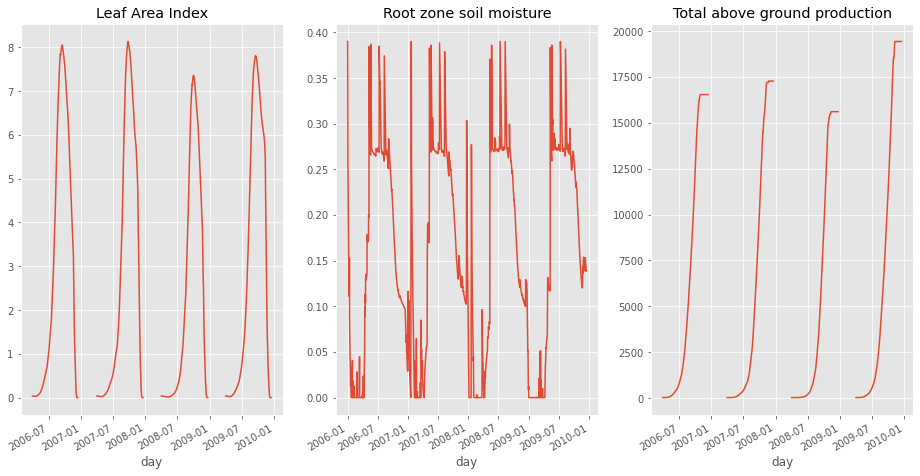

In [388]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8))
df['LAI'].plot(ax=axes[0], title="Leaf Area Index")
df['SM'].plot(ax=axes[1], title="Root zone soil moisture")
df['TAGP'].plot(ax=axes[2], title="Total above ground production")
fig.autofmt_xdate()
